In [1]:
!git clone https://github.com/roneysco/Fake.br-Corpus.git

fatal: destination path 'Fake.br-Corpus' already exists and is not an empty directory.


In [2]:
!ls Fake.br-Corpus/full_texts/

fake  fake-meta-information  true  true-meta-information


In [3]:
import re
import glob
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
%matplotlib inline
sns.set(color_codes=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


FUNÇÕES

In [0]:
# Função que recebe path de pasta contendo arquivos de texto e retorna lista com conteúdo de cada um dos arquivos texto 
def txtToList(path, lista):
  """
    Cria lista de strings (lista) com arquivos txt contidos em path.
    lista deve ser uma lista vazia pré-definida;
    path deve terminar em '/'

  """
  filesList = sorted(glob.glob(path + '*'))
  length = len(filesList)
  for i in range(length):
    file = open(filesList[i], mode='r')
    text = file.read()
    file.close()
    lista.append(text)

In [0]:
# Função que Transforma uma lista de listas em um dataframe
def listToDataFrame(list_,cols_):
  lista = []
  for i in range(len(list_)):  
     lista.append(list_[i].split('\n'))
  
  df = pd.DataFrame(lista,columns=cols)

  return df

In [0]:
# Função pra testar se notícia tem depoimento
def temDepoimento(texto):
    """
    Recebe uma string e traz como resultado 1 se houver depoimento no formado
    aspas duplas + palavras/espaços intercalados + aspas duplas + vírgula +
    palavra.
    
    """
    resultado = int(bool(re.search("\".+\", \w+", texto)))
    return resultado

In [0]:
# Função para alterar todos os dados igual a "None" para vazio, assim é possível converter os dados para os tipos necessários
def removenone(df,cols):
  for col in cols:
    if(df[col].dtype != np.float64 and df[col].dtype != np.int64):
      df[col] = [x.replace('None','') for x in df[col]]
  
  return df

In [0]:
# Função para contagem de sinais de pontuação
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

TRATANDO DATASET

In [9]:
allfakes = []
txtToList('Fake.br-Corpus/full_texts/fake/', allfakes)

alltrue = []
txtToList('Fake.br-Corpus/full_texts/true/', alltrue)

allmetafakes = []
txtToList('Fake.br-Corpus/full_texts/fake-meta-information/', allmetafakes)

allmetatrue = []
txtToList('Fake.br-Corpus/full_texts/true-meta-information/', allmetatrue)

len(alltrue), len(allfakes), len(allmetatrue), len(allmetafakes)

(3600, 3600, 3600, 3600)

In [0]:
# Cria dataframe com coluna 'texto' com todas as fakenews + coluna 'classe' = 0
textfakenews = pd.DataFrame(allfakes)
textfakenews.columns = ['texto']
textfakenews['classe'] = 0

# Cria dataframe com coluna 'texto' c/ todas as truenews + coluna 'classe' = 1
texttruenews = pd.DataFrame(alltrue)
texttruenews.columns = ['texto']
texttruenews['classe'] = 1

In [11]:
cols = ['author' ,'link' ,'category' ,'date of publication' ,'number of tokens' ,'number of words without punctuation' ,'number of types' ,
        'number of links inside the news' ,'number of words in upper case' ,'number of verbs' ,'number of subjuntive and imperative verbs' ,
        'number of nouns' ,'number of adjectives' ,'number of adverbs' ,'number of modal verbs (mainly auxiliary verbs)' ,
        'number of singular first and second personal pronouns' ,'number of plural first personal pronouns' ,'number of pronouns' ,'pausality' ,
        'number of characters' ,'average sentence length' ,'average word length' ,'percentage of news with speeling errors' ,'emotiveness' ,'diversity']

# Cria dataframe com metadados das noticias Fake
metafakenews = listToDataFrame(allmetafakes,cols)
metafakenews.head()

,author,link,category,date of publication,number of tokens,number of words without punctuation,number of types,number of links inside the news,number of words in upper case,number of verbs,number of subjuntive and imperative verbs,number of nouns,number of adjectives,number of adverbs,number of modal verbs (mainly auxiliary verbs),number of singular first and second personal pronouns,number of plural first personal pronouns,number of pronouns,pausality,number of characters,average sentence length,average word length,percentage of news with speeling errors,emotiveness,diversity
0,mrk,https://ceticismopolitico.com/2017/11/30/katia...,politica,2017-11-30,211,185,120,0,6,30,1,46,7,13,5,2,0,26,2.0,815,14.2308,4.40541,0.0,0.263158,0.648649
1,None,https://ceticismopolitico.com/2017/11/24/dr-ra...,politica,2017-11-24,289,254,163,0,0,56,8,64,11,18,11,1,0,20,2.5,1205,18.1429,4.74409,0.00787402,0.241667,0.641732
2,None,https://afolhabrasil.com.br/politica/reinaldo-...,politica,2017-05-23,304,275,170,0,0,45,1,88,9,8,8,0,0,18,1.8125,1344,17.1875,4.88727,0.00363636,0.12782,0.618182
3,None,https://www.diariodobrasil.org/relatorio-assus...,politica,24/07/2017,639,572,316,1,14,87,7,175,39,21,14,0,0,34,2.68,3122,22.88,5.45804,0.00174825,0.229008,0.552448
4,None,https://www.diariodobrasil.org/radialista-amer...,politica,25/07/2017,128,111,82,0,1,21,0,31,6,8,1,1,0,12,0.894737,515,5.84211,4.63964,0.0,0.269231,0.738739


In [12]:
cols = ['author' ,'link' ,'category' ,'date of publication' ,'number of tokens' ,'number of words without punctuation' ,'number of types' ,
        'number of links inside the news' ,'number of words in upper case' ,'number of verbs' ,'number of subjuntive and imperative verbs' ,
        'number of nouns' ,'number of adjectives' ,'number of adverbs' ,'number of modal verbs (mainly auxiliary verbs)' ,
        'number of singular first and second personal pronouns' ,'number of plural first personal pronouns' ,'number of pronouns' ,'pausality' ,
        'number of characters' ,'average sentence length' ,'average word length' ,'percentage of news with speeling errors' ,'emotiveness' ,'diversity']

# Cria dataframe com metadados das noticias True
metatruenews = listToDataFrame(allmetatrue,cols)
metatruenews.head()

,author,link,category,date of publication,number of tokens,number of words without punctuation,number of types,number of links inside the news,number of words in upper case,number of verbs,number of subjuntive and imperative verbs,number of nouns,number of adjectives,number of adverbs,number of modal verbs (mainly auxiliary verbs),number of singular first and second personal pronouns,number of plural first personal pronouns,number of pronouns,pausality,number of characters,average sentence length,average word length,percentage of news with speeling errors,emotiveness,diversity
0,Naira Trindade,http://politica.estadao.com.br/blogs/coluna-do...,politica,13/12/2017,168,148,107,None,0,24,2,43,5,4,3,0,0,7,3.33333,761,24.6667,5.14189,0.0,0.134328,0.722973
1,Marco Rodrigo Almeida,http://www1.folha.uol.com.br/poder/2018/01/194...,politica,12/1/2018,1028,865,474,None,9,135,2,237,56,45,14,3,1,63,2.85965,4205,15.1754,4.86127,0.00115607,0.271505,0.547977
2,"Fernando Zuba , Pedro Ângelo E Renan Ramalho",https://g1.globo.com/mg/minas-gerais/noticia/s...,politica,7/12/2017,540,476,232,None,8,69,0,146,10,20,7,0,0,19,3.04762,2399,22.6667,5.03992,0.0,0.139535,0.487395
3,"Por Anderson Viegas, G1 MS",https://g1.globo.com/mato-grosso-do-sul/notici...,politica,31/10/2017 10h17,8634,7588,2199,0,52,1053,29,2170,443,278,174,0,2,384,3.36334,37381,24.3987,4.92633,0.00250395,0.223705,0.2898
4,Por BBC,https://g1.globo.com/educacao/noticia/por-que-...,politica,05/04/2017 09h08,955,823,452,0,10,96,1,262,36,50,8,0,0,33,3.14286,4239,19.5952,5.15067,0.0,0.240223,0.54921


In [0]:
#Cria um dataframe juntando os textos e os metadados fakes
fakenews = pd.merge(textfakenews,metafakenews,how='inner',left_index=True, right_index=True)
fakenews = removenone(fakenews,fakenews.columns)

#Cria um dataframe juntando os textos e os metadados trues
truenews = pd.merge(texttruenews,metatruenews,how='inner',left_index=True, right_index=True)
truenews = removenone(truenews,truenews.columns)

#Convertendo dados para numericos
colsnumber = fakenews.iloc[:,6:].columns.to_list()

fakenews[colsnumber] = fakenews[colsnumber].apply(pd.to_numeric, errors='coerce')
truenews[colsnumber] = truenews[colsnumber].apply(pd.to_numeric, errors='coerce')


In [0]:
# Preenchendo com a mediana as informações NaN
for nu in colsnumber:
  meanfakecol = fakenews[nu].median(skipna = True)
  meantruecol = truenews[nu].median(skipna = True)

  fakenews[nu].fillna(meanfakecol,inplace=True)
  truenews[nu].fillna(meantruecol,inplace=True)

In [15]:
# Concatena os dois datasets
dfs = [fakenews, truenews]
allnews = pd.concat(dfs)

# Criação de nova feature temDepoimento, com 0 para False e 1 para True.
allnews['temDepoimento'] = allnews['texto'].apply(lambda x: temDepoimento(x))

# Criando nova feature, para contagem de sinais de pontuação
allnews['prop_pont'] = allnews['texto'].apply(lambda x: count_punct(x))

#Removendo colunas que não serão utilizadas
allnews.drop(columns=['date of publication','link','author','category'],inplace=True)

# Reset no index
allnews.reset_index(drop=True,inplace=True)

# Exibe primeiros registros do dataframe allnews
allnews.head(5)

,texto,classe,number of tokens,number of words without punctuation,number of types,number of links inside the news,number of words in upper case,number of verbs,number of subjuntive and imperative verbs,number of nouns,number of adjectives,number of adverbs,number of modal verbs (mainly auxiliary verbs),number of singular first and second personal pronouns,number of plural first personal pronouns,number of pronouns,pausality,number of characters,average sentence length,average word length,percentage of news with speeling errors,emotiveness,diversity,temDepoimento,prop_pont
0,Kátia Abreu diz que vai colocar sua expulsão e...,0,211,185,120,0.0,6,30,1,46,7,13,5,2,0,26,2.000000,815,14.23080,4.40541,0.000000,0.263158,0.648649,0,3.5
1,"Dr. Ray peita Bolsonaro, chama-o de conservad...",0,289,254,163,0.0,0,56,8,64,11,18,11,1,0,20,2.500000,1205,18.14290,4.74409,0.007874,0.241667,0.641732,0,2.7
2,Reinaldo Azevedo desmascarado pela Polícia Fed...,0,304,275,170,0.0,0,45,1,88,9,8,8,0,0,18,1.812500,1344,17.18750,4.88727,0.003636,0.127820,0.618182,0,1.9
3,Relatório assustador do BNDES mostra dinheiro ...,0,639,572,316,1.0,14,87,7,175,39,21,14,0,0,34,2.680000,3122,22.88000,5.45804,0.001748,0.229008,0.552448,1,2.3
4,"Radialista americano fala sobre o PT: ""Eles ve...",0,128,111,82,0.0,1,21,0,31,6,8,1,1,0,12,0.894737,515,5.84211,4.63964,0.000000,0.269231,0.738739,0,5.5


In [16]:
allnews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 25 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   texto                                                  7200 non-null   object 
 1   classe                                                 7200 non-null   int64  
 2   number of tokens                                       7200 non-null   int64  
 3   number of words without punctuation                    7200 non-null   int64  
 4   number of types                                        7200 non-null   int64  
 5   number of links inside the news                        7200 non-null   float64
 6   number of words in upper case                          7200 non-null   int64  
 7   number of verbs                                        7200 non-null   int64  
 8   number of subjuntive and imperative verbs       

GRÁFICOS

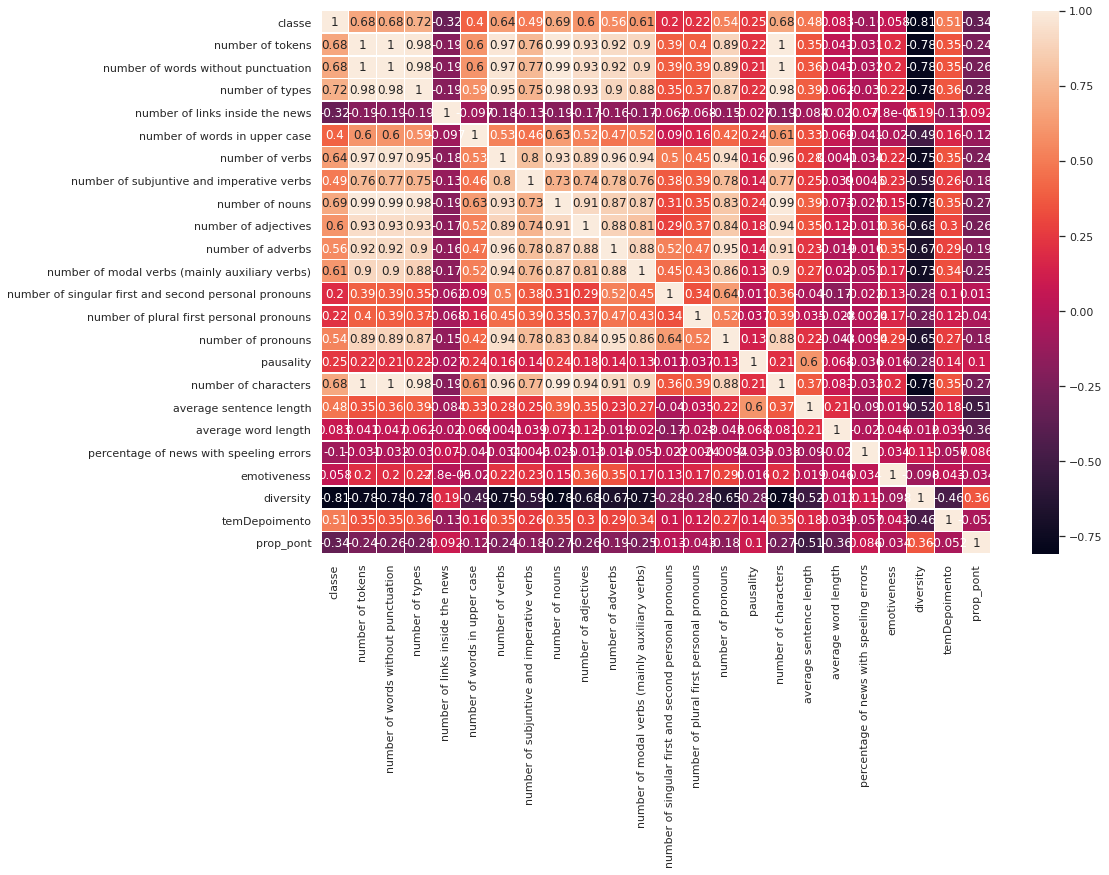

In [17]:
# Correlação entre variáveis
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(allnews.corr(), annot=True, linewidths=.5, ax=ax)

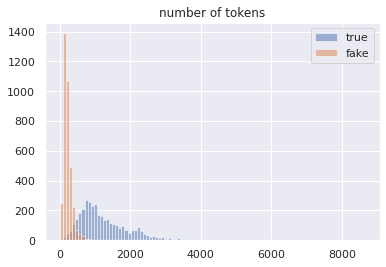

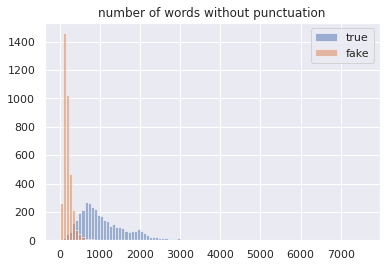

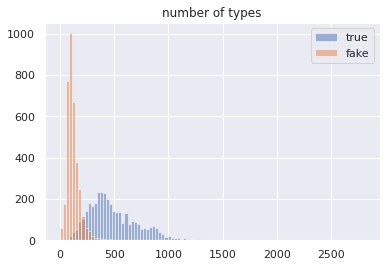

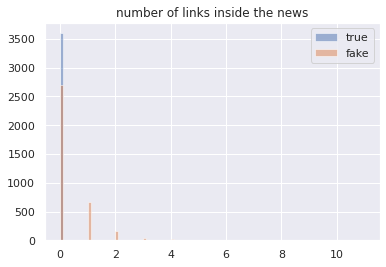

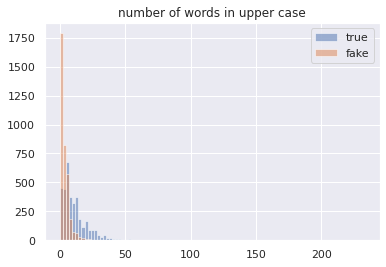

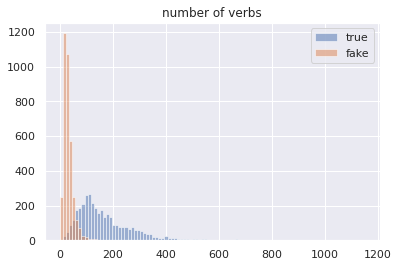

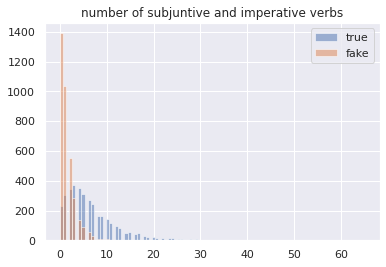

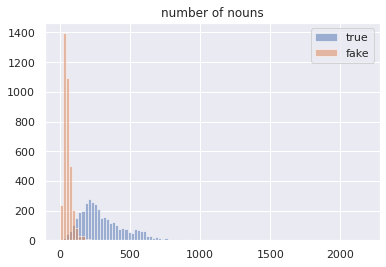

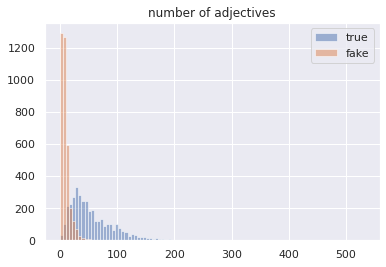

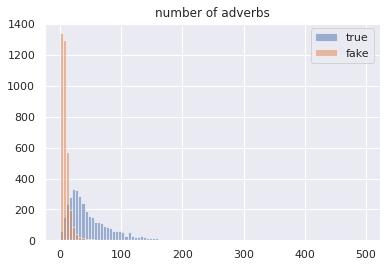

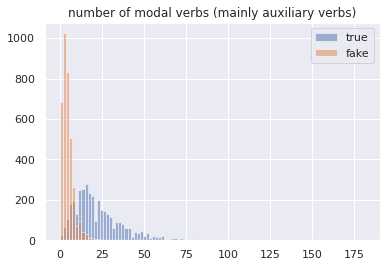

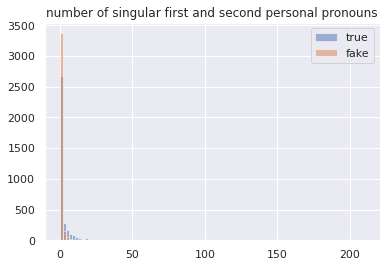

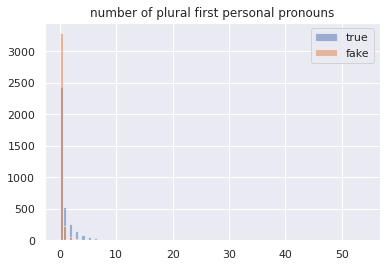

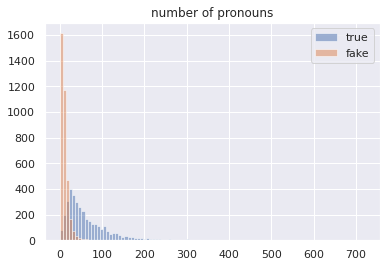

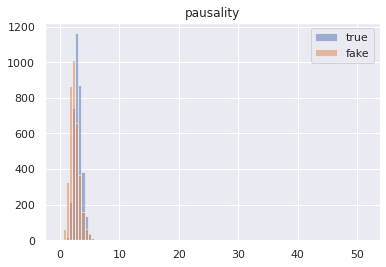

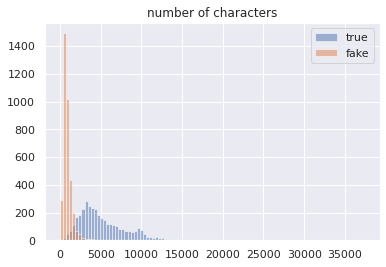

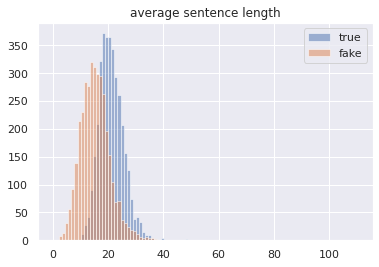

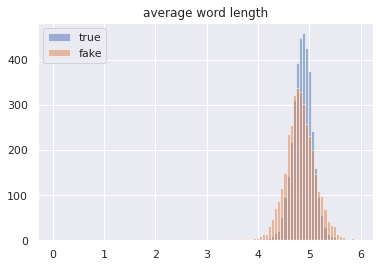

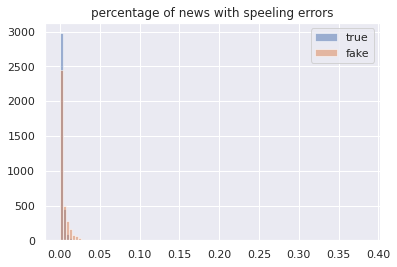

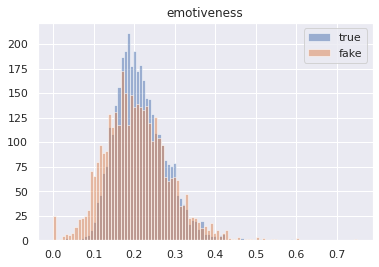

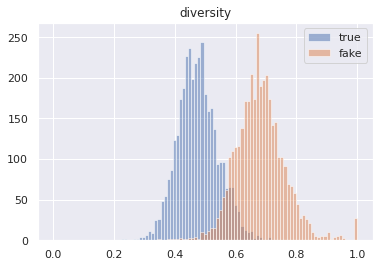

In [18]:
# Comparando todas as variáveis independentes com a variável 
for col in colsnumber:
  maxcol = allnews[col].max()
  bins = np.linspace(0, maxcol, 100)
  plt.hist(allnews[allnews['classe']==1][col], bins, alpha=0.5, label='true')
  plt.hist(allnews[allnews['classe']==0][col], bins, alpha=0.5, label='fake')
  plt.legend(loc='best')
  plt.title(col)
  plt.show()

REGRESSÃO LOGISTICA

In [0]:
X = allnews.iloc[:,2:].values
y = allnews.iloc[:,1].values

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=42)

In [21]:
logit = LogisticRegression()

logit.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
print("Acuracia do modelo: ", logit.score(X_test, y_test))

Acuracia do modelo:  0.9490740740740741


In [23]:
print('Coeficiente')
print(logit.coef_)
print('\nIntercept')
print(logit.intercept_)

Coeficiente
[[ 0.01793351  0.03351635 -0.02112086 -0.26694816 -0.13660693 -0.00680187
   0.0303734  -0.05728377 -0.08693266 -0.15540314 -0.12271277  0.11125988
  -0.00992827 -0.08320624 -0.05429281  0.00141881  0.04574302 -0.63889867
  -0.00099723 -0.02608899 -0.09990654  0.13010992 -0.58872563]]

Intercept
[-0.13216946]


In [24]:
y_pred = logit.predict(X_test)
y_pred_proba = logit.predict_proba(X_test)

print('pred')
print(y_pred)
print('\nproba')
print(y_pred_proba)

pred
[0 0 1 ... 0 1 0]

proba
[[0.99177388 0.00822612]
 [0.95853415 0.04146585]
 [0.00161959 0.99838041]
 ...
 [0.99330857 0.00669143]
 [0.00110551 0.99889449]
 [0.97915463 0.02084537]]


In [25]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[1034   53]
 [  57 1016]]


In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1087
           1       0.95      0.95      0.95      1073

    accuracy                           0.95      2160
   macro avg       0.95      0.95      0.95      2160
weighted avg       0.95      0.95      0.95      2160



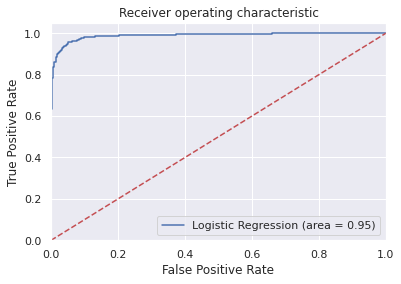

In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logit.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logit.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()